In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from object_detection.dataset.object_detection import ObjectDetectionDataset
from object_detection.visualization.utils import display_image_batch, display_bounding_boxes, display_grid
from object_detection.backbone_cnn.resnet50 import ResNet50
from object_detection.region_processing.anchor import generate_anchor_points

# Data

In [8]:
image_width = 640
image_height = 480
annotation_path = '../data/div2k_hr/tutorial/annotations.xml'
image_dir = '../data/div2k_hr/tutorial/images'
label_to_index = {'pad': -1, 'camel': 0, 'bird': 1}
index_to_label = {v:k for k, v in label_to_index.items()}

In [12]:
dataset = ObjectDetectionDataset(annotation_path, image_dir, (image_height, image_width), label_to_index)
dataloader = DataLoader(dataset, batch_size=2)

In [14]:
image_batch, bounding_box_batch, label_batch = next(iter(dataloader))

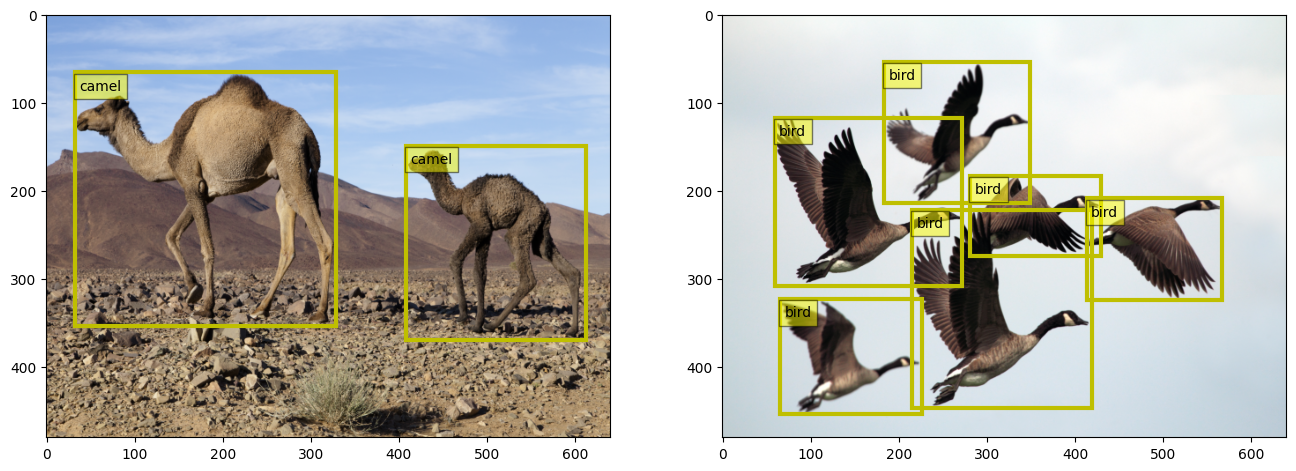

In [29]:
# Displaying images and bounding boxes
label_image1 = [index_to_label[idx.item()] for idx in label_batch[0].long()]
label_image2 = [index_to_label[idx.item()] for idx in label_batch[1].long()]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

display_image_batch(image_batch, axes)
display_bounding_boxes(bounding_box_batch[0], axes[0], class_labels=label_image1)
display_bounding_boxes(bounding_box_batch[1], axes[1], class_labels=label_image2)

# Feature maps

In [47]:
backbone = ResNet50(num_layers=4)

In [51]:
feature_map = backbone(image_batch)
num_channels, feature_map_height, feature_map_width = feature_map.size(dim=1), feature_map.size(dim=2), feature_map.size(dim=3)
num_channels, feature_map_height, feature_map_width

(2048, 15, 20)

In [53]:
# The image has been downscaled by a factor of ...
width_scale_factor = image_width // feature_map_width
height_scale_factor = image_height // feature_map_height
height_scale_factor, width_scale_factor

(32, 32)

## Visualizing features

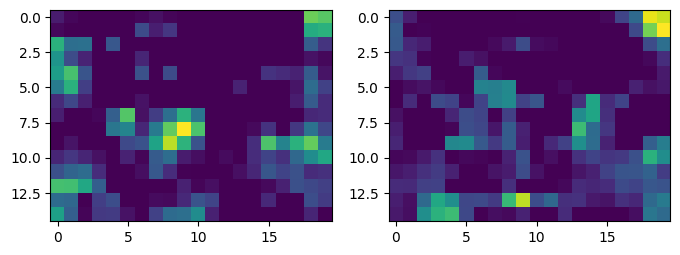

In [57]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

features = [features[0].detach().numpy() for features in feature_map[:2]]

display_image_batch(features, axes)

# Anchors

In [66]:
anchor_xs, anchor_ys = generate_anchor_points(image_size=(feature_map_height, feature_map_width))

In [67]:
# Project anchor points onto the original image
projected_anchor_xs = anchor_xs.clone() * width_scale_factor 
projected_anchor_ys = anchor_ys.clone() * height_scale_factor

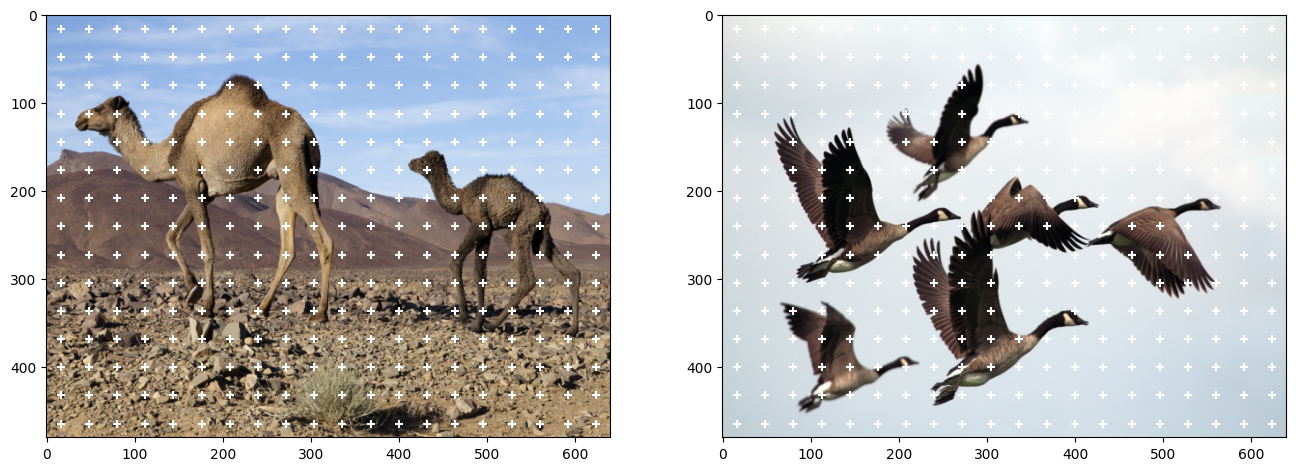

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
 
display_image_batch(image_batch, axes)
display_grid(projected_anchor_xs, projected_anchor_ys, axes[0])
display_grid(projected_anchor_xs, projected_anchor_ys, axes[1])